# Tutorial 3: human placenta architecture dataset

## Loading package

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc

In [2]:
import SpaLORA

In [3]:
# Environment configuration. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/opt/R/4.0.3/lib/R'

## Loading data

In [4]:
# read data
file_fold = '/root/human_placenta/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'humanplacenta_rna.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'humanplacenta_atac.h5ad')  

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

In [5]:
# Specify data type
data_type = 'Slide-tags'

# Fix random seed
from SpaLORA.preprocess import fix_seed
random_seed = 2022
fix_seed(random_seed)

## Pre-processing data

In [6]:
from SpaLORA.preprocess import clr_normalize_each_cell, pca, lsi

sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1.obsm['raw_feat'] = adata_omics1[:, adata_omics1.var['highly_variable']].X.copy()
adata_omics1.obsm['feat'] = pca(adata_omics1[:, adata_omics1.var['highly_variable']], n_comps=adata_omics2.n_vars-1)

adata_omics2 = clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

## Constructing neighbor graph

In [7]:
from SpaLORA.preprocess import construct_neighbor_graph
data = construct_neighbor_graph(adata_omics1, adata_omics2, datatype=data_type)

## Training the model

In [8]:
# define model
from SpaLORA.SpaLORA_pyG import Train_SpaLORA
model = Train_SpaLORA(data, datatype=data_type, device=device)

# train model
output = model.train()

  0%|          | 0/200 [00:00<?, ?it/s]/root/miniconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/root/SGlocal/SpaLORA/model.py:136: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 200/200 [00:04<00:00, 40.34it/s]

Model training finished!



In [9]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata.obsm['SpaLORA'] = output['SpaLORA'].copy()
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

## Cross-omics integrative analysis

In [10]:
from SpaLORA.utils import clustering
clustering(adata, key='SpaLORA', add_key='SpaLORA', n_clusters=10, use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/root/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


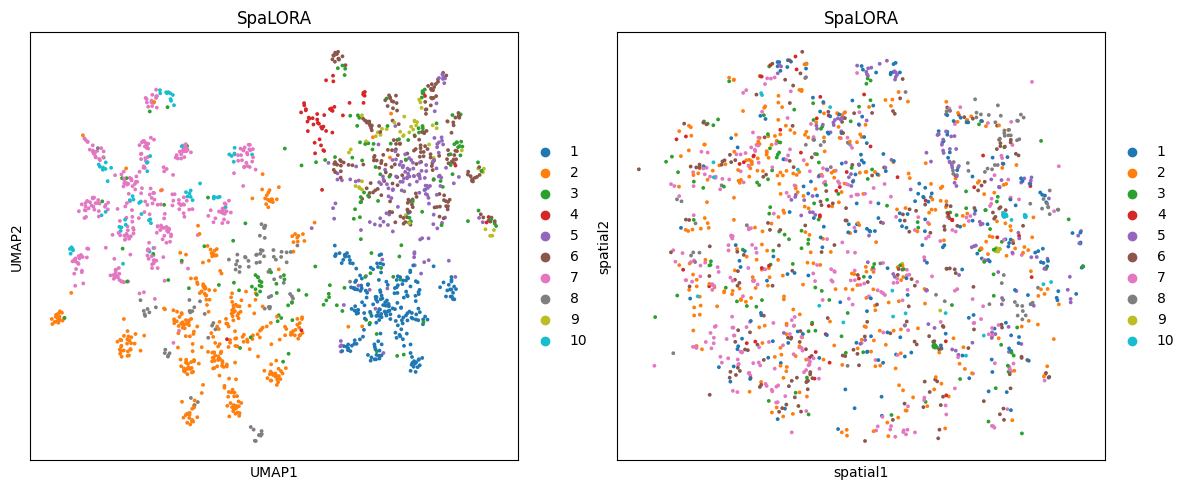

In [11]:
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata, use_rep='SpaLORA', n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpaLORA', ax=ax_list[0], title='SpaLORA', s=30, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpaLORA', ax=ax_list[1], title='SpaLORA', s=30, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()